In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
# Load ECG Images
def load_ecg_images(folder_path, label, img_size=(128, 128)):
    images, labels = [], []
    for file in os.listdir(folder_path):
        if file.endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(os.path.join(folder_path, file), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_size) / 255.0  # Normalize
            images.append(img)
            labels.append(label)
    return images, labels


In [3]:
# Define dataset paths
dataset_path = "sample"
normal_path = os.path.join(dataset_path, "normal")
abnormal_path = os.path.join(dataset_path, "abnormal")

# Load normal and abnormal ECG images
print("Loading images...")
normal_images, normal_labels = load_ecg_images(normal_path, 0)
abnormal_images, abnormal_labels = load_ecg_images(abnormal_path, 1)
print("Images loaded successfully.")

# Convert lists to NumPy arrays
X = np.array(normal_images + abnormal_images).reshape(-1, 128, 128, 1)
y = to_categorical(np.array(normal_labels + abnormal_labels), num_classes=2)
print("Data converted to NumPy arrays.")

# Print number of images
print(f"Number of normal images: {len(normal_images)}")
print(f"Number of abnormal images: {len(abnormal_images)}")

Loading images...
Images loaded successfully.
Data converted to NumPy arrays.
Number of normal images: 284
Number of abnormal images: 233


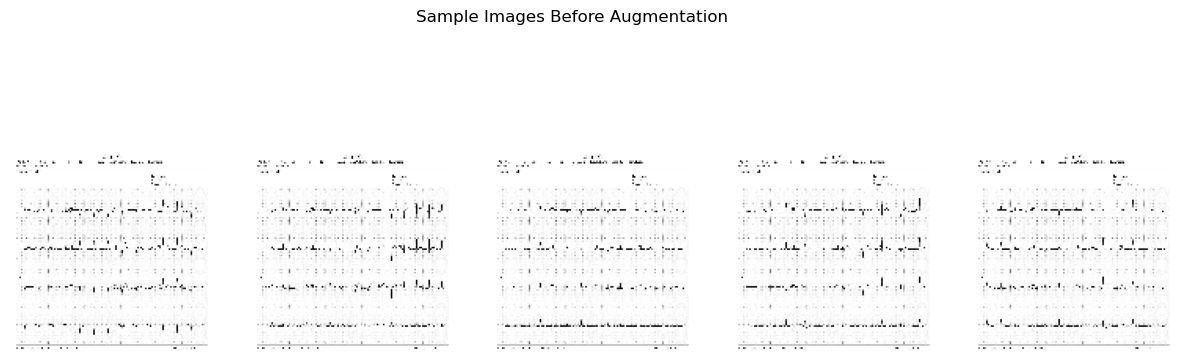

Splitting dataset...
Dataset split successfully.


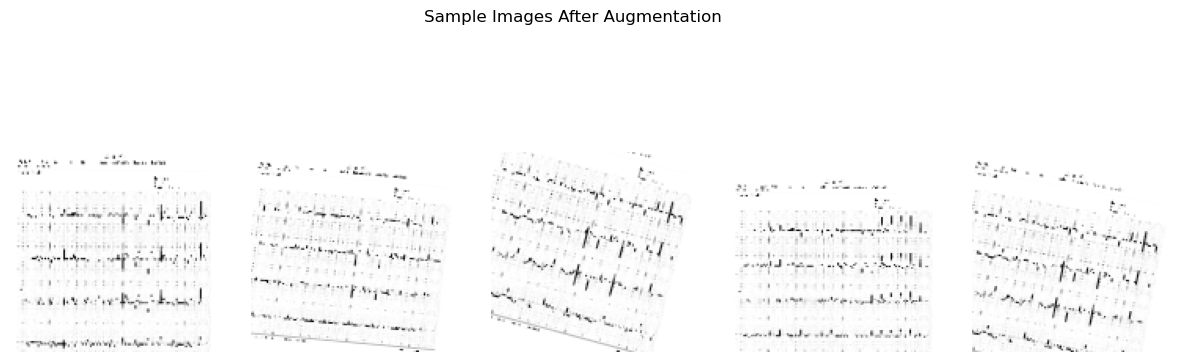

In [4]:
# Visualize images before augmentation
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X[i].reshape(128, 128), cmap='gray')
    ax.axis("off")
plt.suptitle("Sample Images Before Augmentation")
plt.show()

# Split dataset
print("Splitting dataset...")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Dataset split successfully.")

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)
datagen.fit(X_train)

# Visualize images after augmentation
augmented_images = [datagen.flow(X_train, batch_size=1).__next__()[0] for _ in range(5)]
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(augmented_images[i].reshape(128, 128), cmap='gray')
    ax.axis("off")
plt.suptitle("Sample Images After Augmentation")
plt.show()

In [5]:
# Define CNN Model
def create_model(learning_rate=0.001, dropout_rate=0.3, num_filters=32, num_layers=5, activation='relu'):
    model = Sequential()
    model.add(Input(shape=(128, 128, 1)))
    for _ in range(num_layers):
        model.add(Conv2D(num_filters, (3, 3), activation=activation, padding='same'))
        model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=learning_rate), metrics=["accuracy"])
    return model


In [6]:
model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 103,234 (403.26 KB)

 Trainable params: 103,234 (403.26 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Hyperparameter Grid
param_grid = {
    'model__learning_rate': [0.001],
    'model__dropout_rate': [0.3],
    'model__num_filters': [32],
    'model__num_layers': [5],
    'model__activation': ['elu'],  
    'batch_size': [16],
    'epochs': [30,50]
}

In [8]:
# Perform Grid Search
print("Performing Grid Search...")
model = KerasClassifier(model=create_model, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3, return_train_score=True)
grid_result = grid.fit(X_train, y_train)

print("Grid Search Completed.")

Performing Grid Search...
Grid Search Completed.


In [9]:
print(f"Best Model Parameters: {grid_result.best_params_}")
print(f"Best Model Validation Accuracy: {grid_result.best_score_}")
print("Grid Search Iterations:")
for i, params in enumerate(grid_result.cv_results_['params']):
    print(f"Iteration {i+1}: {params} - Mean Accuracy: {grid_result.cv_results_['mean_test_score'][i]}")


Best Model Parameters: {'batch_size': 16, 'epochs': 50, 'model__activation': 'elu', 'model__dropout_rate': 0.3, 'model__learning_rate': 0.001, 'model__num_filters': 32, 'model__num_layers': 5}
Best Model Validation Accuracy: 0.9346415599985894
Grid Search Iterations:
Iteration 1: {'batch_size': 16, 'epochs': 30, 'model__activation': 'elu', 'model__dropout_rate': 0.3, 'model__learning_rate': 0.001, 'model__num_filters': 32, 'model__num_layers': 5} - Mean Accuracy: 0.9273070277513312
Iteration 2: {'batch_size': 16, 'epochs': 50, 'model__activation': 'elu', 'model__dropout_rate': 0.3, 'model__learning_rate': 0.001, 'model__num_filters': 32, 'model__num_layers': 5} - Mean Accuracy: 0.9346415599985894


In [10]:
from tensorflow.keras.models import save_model

best_model = grid_result.best_estimator_.model_  # Use model_ instead of model
save_model(best_model, "ecg_cnn_model.h5")


In [11]:
# Train Best Model and get history
print("Training best model...")
history = best_model.fit(datagen.flow(X_train, y_train, batch_size=16), validation_data=(X_val, y_val), epochs=50)
print("Best model training completed.")



Training best model...


C:\Users\nsai0\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.7130 - loss: 0.8818 - val_accuracy: 0.7788 - val_loss: 0.5274
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.7426 - loss: 0.5712 - val_accuracy: 0.8654 - val_loss: 0.2871
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.7863 - loss: 0.4841 - val_accuracy: 0.8365 - val_loss: 0.3154
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.7786 - loss: 0.4303 - val_accuracy: 0.9231 - val_loss: 0.1804
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.8050 - loss: 0.4395 - val_accuracy: 0.9038 - val_loss: 0.2085
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8356 - loss: 0.3748 - val_accuracy: 0.9038 - val_loss: 0.2029
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.8616 - loss: 0.3113 - val_accuracy: 0.9135 - val_loss: 0.1858
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.8671 - loss: 0.3137 - val_accuracy: 0.9423 - v

In [12]:
# Make predictions
y_pred = best_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


In [13]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94        62
           1       0.87      0.98      0.92        42

    accuracy                           0.93       104
   macro avg       0.93      0.94      0.93       104
weighted avg       0.94      0.93      0.93       104



Generating confusion matrix...


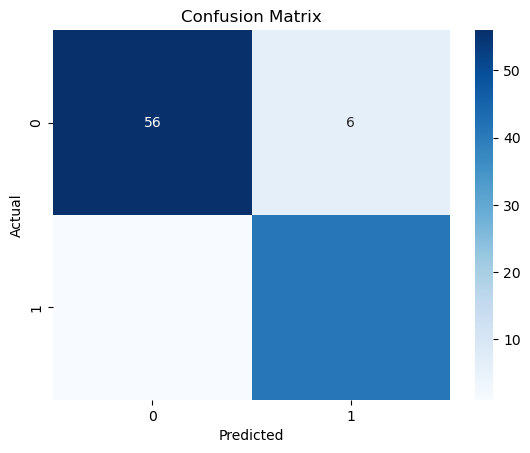

In [14]:
# Generate confusion matrix
print("Generating confusion matrix...")
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


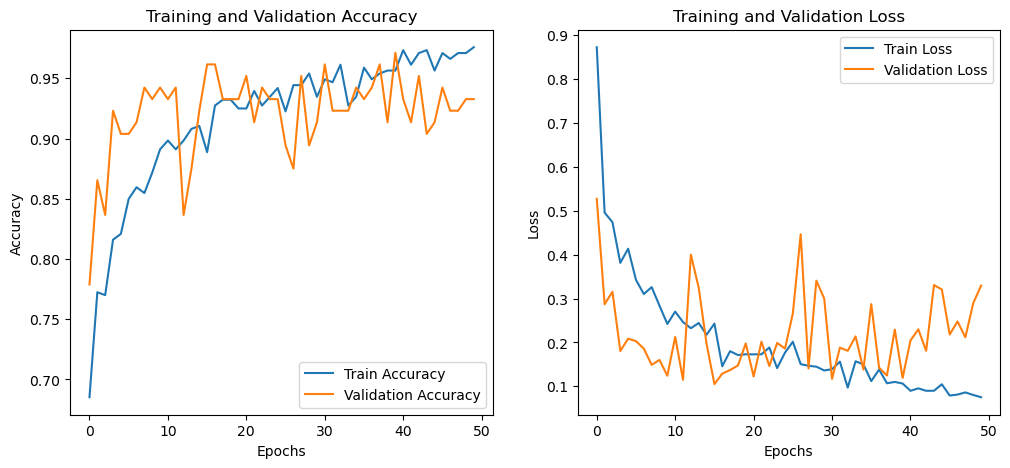

In [15]:
# Plot function
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# Call this function after training
plot_training_history(history)


In [16]:
from tensorflow.keras.models import save_model

best_model = grid_result.best_estimator_.model_  # Use model_ instead of model
save_model(best_model, "ecg_cnn_model.keras")